In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
#to ignore warnings
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LinearRegression

In [3]:
data = pd.read_csv("Dataset/Training/Features_Variant_5.csv")

column_names_updated = [
    "Page_Popularity_Likes", "Page_Checkins", "Page_Talking_About", "Page_Category",
    "Derived_1", "Derived_2", "Derived_3", "Derived_4", "Derived_5",
    "Derived_6", "Derived_7", "Derived_8", "Derived_9", "Derived_10",
    "Derived_11", "Derived_12", "Derived_13", "Derived_14", "Derived_15",
    "Derived_16", "Derived_17", "Derived_18", "Derived_19", "Derived_20",
    "Derived_21", "Derived_22", "Derived_23", "Derived_24", "Derived_25",
    "CC1_Total_Comments", "CC2_Comments_Last_24h", "CC3_Comments_48_to_24h",
    "CC4_Comments_First_24h", "CC5_CC2_CC3_Difference", "Base_Time",
    "Post_Length", "Post_Share_Count", "Post_Promotion_Status", "H_Local",
    "Published_Sunday", "Published_Monday", "Published_Tuesday",
    "Published_Wednesday", "Published_Thursday", "Published_Friday",
    "Published_Saturday", "BaseDate_Sunday", "BaseDate_Monday",
    "BaseDate_Tuesday", "BaseDate_Wednesday", "BaseDate_Thursday",
    "BaseDate_Friday", "BaseDate_Saturday", "Target_Comment_Volume"
]

data.columns = column_names_updated

In [4]:
category_mapping = {
    1: "Product/service", 2: "Public figure", 3: "Retail and consumer merchandise",
    4: "Athlete", 5: "Education website", 6: "Arts/entertainment/nightlife",
    7: "Aerospace/defense", 8: "Actor/director", 9: "Professional sports team",
    10: "Travel/leisure", 11: "Arts/humanities website", 12: "Food/beverages",
    13: "Record label", 14: "Movie", 15: "Song", 16: "Community",
    17: "Company", 18: "Artist", 19: "Non-governmental organization (NGO)",
    20: "Media/news/publishing", 21: "Cars", 22: "Clothing", 23: "Local business",
    24: "Musician/band", 25: "Politician", 26: "News/media website",
    27: "Education", 28: "Author", 29: "Sports event", 30: "Restaurant/cafe",
    31: "School sports team", 32: "University", 33: "TV show",
    34: "Website", 35: "Outdoor gear/sporting goods", 36: "Political party",
    37: "Sports league", 38: "Entertainer", 39: "Church/religious organization",
    40: "Non-profit organization", 41: "Automobiles and parts", 42: "TV channel",
    43: "Telecommunication", 44: "Entertainment website", 45: "Shopping/retail",
    46: "Personal blog", 47: "App page", 48: "Vitamins/supplements",
    49: "Professional services", 50: "Movie theater", 51: "Software",
    52: "Magazine", 53: "Electronics", 54: "School", 55: "Just for fun",
    56: "Club", 57: "Comedian", 58: "Sports venue", 59: "Sports/recreation/activities",
    60: "Publisher", 61: "TV network", 62: "Health/medical/pharmacy",
    63: "Studio", 64: "Home decor", 65: "Jewelry/watches", 66: "Writer",
    67: "Health/beauty", 68: "Music video", 69: "Appliances", 70: "Computers/technology",
    71: "Insurance company", 72: "Music award", 73: "Recreation/sports website",
    74: "Reference website", 75: "Business/economy website", 76: "Bar",
    77: "Album", 78: "Games/toys", 79: "Camera/photo", 80: "Book",
    81: "Producer", 82: "Landmark", 83: "Cause", 84: "Organization",
    85: "TV/movie award", 86: "Hotel", 87: "Health/medical/pharmaceuticals",
    88: "Transportation", 89: "Local/travel website", 90: "Musical instrument",
    91: "Radio station", 92: "Other", 93: "Computers", 94: "Phone/tablet",
    95: "Coach", 96: "Tools/equipment", 97: "Internet/software",
    98: "Bank/financial institution", 99: "Society/culture website",
    100: "Small business", 101: "News personality", 102: "Teens/kids website",
    103: "Government official", 104: "Photographer", 105: "Spas/beauty/personal care",
    106: "Video game"
}

data["Page_Category"] = data["Page_Category"].map(category_mapping)
data['Post_Promotion_Status'] = data['Post_Promotion_Status'].replace({0: 'No', 1: 'Yes'})

published_day_mapping = {
    "Published_Sunday": "Sunday",
    "Published_Monday": "Monday",
    "Published_Tuesday": "Tuesday",
    "Published_Wednesday": "Wednesday",
    "Published_Thursday": "Thursday",
    "Published_Friday": "Friday",
    "Published_Saturday": "Saturday"
}

basedate_day_mapping = {
    "BaseDate_Sunday": "Sunday",
    "BaseDate_Monday": "Monday",
    "BaseDate_Tuesday": "Tuesday",
    "BaseDate_Wednesday": "Wednesday",
    "BaseDate_Thursday": "Thursday",
    "BaseDate_Friday": "Friday",
    "BaseDate_Saturday": "Saturday"
}

data['Published_Day'] = data[[*published_day_mapping.keys()]].idxmax(axis=1).map(published_day_mapping)
data['BaseDate_Day'] = data[[*basedate_day_mapping.keys()]].idxmax(axis=1).map(basedate_day_mapping)
data.drop(columns=list(published_day_mapping.keys()) + list(basedate_day_mapping.keys()), inplace=True)


Our target columns is the amount of Comments in the next H_Local hours. Therefore, to prepare our Feautre Engeneering, we first want to bring this to comparable scale, in this case Comments per hour, so that we can better compare this feature and work with it.

In [5]:
data['Hourly_Target_Volume'] = data['Target_Comment_Volume'] / data['H_Local']


Now we split our dataset, to ensure feat engeneering is only calculated based on values of our train dataset.

In [6]:

train_df, test_df = train_test_split(
    data, test_size=0.2, random_state=42
)

train_df_raw = train_df.copy()
test_df_raw = test_df.copy()

### Feature: Comment Section Turned off
If the post has a multiple shares (25 percentile), but no comments have been tracked, the the comment section is marked as off. The same threshold value from the train dataset is also used for the test dataset.

In [7]:
share_thresh = np.percentile(train_df['Post_Share_Count'], 25)

mask_time_enough = train_df['Base_Time'] >= 10
mask_no_comments = train_df['CC1_Total_Comments'] == 0
mask_high_share  = train_df['Post_Share_Count']      > share_thresh

train_df['Comments_Section_Off'] = 0
train_df.loc[
    mask_time_enough & mask_no_comments & mask_high_share,
    'Comments_Section_Off'
] = 1

# test
mask_time_enough = test_df['Base_Time'] >= 10
mask_no_comments = test_df['CC1_Total_Comments'] == 0
mask_high_share  = test_df['Post_Share_Count']      > share_thresh

test_df['Comments_Section_Off'] = 0
test_df.loc[
    mask_time_enough & mask_no_comments & mask_high_share,
    'Comments_Section_Off'
] = 1

off_count_train = train_df['Comments_Section_Off'].sum()
off_count_test  = test_df['Comments_Section_Off'].sum()

print(f"Train set:   {off_count_train} posts with Comments_Section_Off = 1")
print(f"Test set:    {off_count_test} posts with Comments_Section_Off = 1")
train_df

Train set:   5641 posts with Comments_Section_Off = 1
Test set:    1476 posts with Comments_Section_Off = 1


,Page_Popularity_Likes,Page_Checkins,Page_Talking_About,Page_Category,Derived_1,Derived_2,Derived_3,Derived_4,Derived_5,Derived_6,...,Base_Time,Post_Length,Post_Share_Count,Post_Promotion_Status,H_Local,Target_Comment_Volume,Published_Day,BaseDate_Day,Hourly_Target_Volume,Comments_Section_Off
179657,338997,0,128,Community,0.0,60.0,9.015831,6.0,10.562030,0.0,...,29,6,75,No,24,0,Thursday,Friday,0.000000,0
174214,34008,0,11863,Artist,0.0,539.0,38.773333,29.0,47.462614,0.0,...,58,1173,31,No,24,0,Sunday,Tuesday,0.000000,0
48858,4233,0,1005,Artist,0.0,45.0,6.016160,4.0,6.992577,0.0,...,39,60,2,No,24,0,Saturday,Monday,0.000000,0
191955,273093,0,17964,Entertainer,0.0,508.0,55.641834,28.0,82.807199,0.0,...,65,222,5,No,24,0,Thursday,Sunday,0.000000,0
21587,259412,0,991,Actor/director,0.0,46.0,7.441048,5.0,7.983185,0.0,...,56,167,21,No,24,0,Sunday,Tuesday,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119879,68306,0,3811,Public figure,0.0,113.0,26.452548,19.0,23.294552,0.0,...,32,430,2,No,24,0,Saturday,Sunday,0.000000,0
103694,1294733,11,11511,Movie,0.0,383.0,110.568750,70.5,107.312605,0.0,...,50,0,7643,No,24,4,Friday,Sunday,0.166667,0
131932,1501468,0,50185,Actor/director,0.0,1175.0,131.313356,92.0,154.879580,0.0,...,55,13,100,No,24,1,Thursday,Sunday,0.041667,0
146867,41813,0,10840,Public figure,0.0,258.0,40.147766,20.0,50.209275,0.0,...,51,18,5,No,24,0,Sunday,Tuesday,0.000000,0


### Features: Hourly Rates for past comment values
The CC1 to CC4 values are manipulates based on the base time, as f.e. for a basetime of 10 only 10 past hours were recoreded, not 24. To come up for this, the hourly rates are calculated as features, providing 4 new features.

In [8]:

train_df['Hourly_Rate_CC1'] = (
    train_df['CC1_Total_Comments']
    / np.maximum(train_df['Base_Time'], 1)
)
test_df['Hourly_Rate_CC1'] = (
    test_df['CC1_Total_Comments']
    / np.maximum(test_df['Base_Time'], 1)
)

# CC2 (last 24h)
train_df['Hourly_Rate_CC2'] = (
    train_df['CC2_Comments_Last_24h']
    / np.maximum(np.minimum(24, train_df['Base_Time']), 1)
)
test_df['Hourly_Rate_CC2'] = (
    test_df['CC2_Comments_Last_24h']
    / np.maximum(np.minimum(24, test_df['Base_Time']), 1)
)

# CC3 (24–48h)
train_df['Hourly_Rate_CC3'] = (
    train_df['CC3_Comments_48_to_24h']
    / np.maximum(
        np.minimum(24, train_df['Base_Time'] - 24),
        1
    )
)
test_df['Hourly_Rate_CC3'] = (
    test_df['CC3_Comments_48_to_24h']
    / np.maximum(
        np.minimum(24, test_df['Base_Time'] - 24),
        1
    )
)

# CC4 (first 24h)
train_df['Hourly_Rate_CC4'] = (
    train_df['CC4_Comments_First_24h']
    / np.maximum(
        np.minimum(24, train_df['Base_Time'] - 48),
        1
    )
)
test_df['Hourly_Rate_CC4'] = (
    test_df['CC4_Comments_First_24h']
    / np.maximum(
        np.minimum(24, test_df['Base_Time'] - 48),
        1
    )
)


### Feature: Aggregate on Page Category
Simple aggregate feature that output the average future comments per hour based on the category of the page that did the post.

In [9]:

cat_target = (
    train_df
    .groupby('Page_Category')['Hourly_Target_Volume']
    .mean()
    .reset_index()
    .rename(columns={'Hourly_Target_Volume': 'Category_Target_Mean'})
)
train_df = train_df.merge(cat_target, on='Page_Category', how='left')

# test: merge using train’s mapping
test_df = test_df.merge(cat_target, on='Page_Category', how='left')

### Features: Aggregates on Page Popularity, Checkins and Talking About
Bin these continiues variables into 30 groups. Based on the range of that group, calculate the average amount of future comments per hour

In [10]:

cont_feats = ['Page_Popularity_Likes', 'Page_Checkins', 'Page_Talking_About']
bin_edges = {}
bin_means = {}

for feat in cont_feats:
    bin_col   = feat + '_bin'
    mean_col  = feat + '_Bin_Target_Mean'

    # --- train: q‐cut, mean, map, save edges/measures, drop bin col
    train_df[bin_col] = pd.qcut(
        train_df[feat], q=30, duplicates='drop'
    )
    bmean = train_df.groupby(bin_col)['Hourly_Target_Volume'].mean()
    train_df[mean_col] = train_df[bin_col].map(bmean)
    bin_edges[feat] = train_df[bin_col].cat.categories
    bin_means[feat] = bmean
    train_df.drop(columns=[bin_col], inplace=True)

    # --- test: cut on train’s edges, map train’s means, drop bin col
    test_df[bin_col] = pd.cut(
        test_df[feat],
        bins=bin_edges[feat]
    )
    test_df[mean_col] = test_df[bin_col].map(bin_means[feat])
    test_df.drop(columns=[bin_col], inplace=True)

### Feature: Ratio between CommentsLast 24 hours and Future Comments
Calculate the average ratio between the hourly amount of future comments and the hourly amount of comments from the last 24 hours. This is done on aggregates, so that we can also calculate this feature on the test dataset, without leaking data. Therefore, the aggregate is done based on the Hourly CC2 rate: Meaning we will have 30 distinct ratios assigned to each bin.

If the comment section is turned off, the value is simply set to 0.

In [11]:
future_rate = train_df['Target_Comment_Volume'] / train_df['H_Local']
past_rate   = train_df['Hourly_Rate_CC2']

# 2) individual ratio = future_rate / past_rate, but zero if past_rate==0
train_df['Ratio_Indiv'] = np.where(
    past_rate == 0,
    0,
    future_rate / past_rate
)

# 3) exclude “off” rows from aggregation
train_df.loc[train_df['Comments_Section_Off'] == 1, 'Ratio_Indiv'] = np.nan

# 4) create 10 quantile bins on Hourly_Rate_CC2 (train only)
train_df['CC2_ratio_bin'] = pd.qcut(
    train_df['Hourly_Rate_CC2'],
    q=100,
    duplicates='drop'
)

# 5) compute mean ratio per CC2 bin (NaNs ignored)
ratio_group = (
    train_df
    .groupby('CC2_ratio_bin')['Ratio_Indiv']
    .mean()
    .reset_index()
    .rename(columns={'Ratio_Indiv': 'Ratio_Agg_Past24h_vs_Future'})
)

# 6) merge aggregate back onto train and zero‑out “off” rows
train_df = train_df.merge(ratio_group, on='CC2_ratio_bin', how='left')
train_df.loc[train_df['Comments_Section_Off'] == 1, 'Ratio_Agg_Past24h_vs_Future'] = 0

# 7) save the bin edges & clean up
ratio_bins = train_df['CC2_ratio_bin'].cat.categories
train_df.drop(columns=['Ratio_Indiv', 'CC2_ratio_bin'], inplace=True)


# --- TEST: apply train‑derived aggregates ---
# 1) bin test rows using train’s CC2 edges
test_df['CC2_ratio_bin'] = pd.cut(
    test_df['Hourly_Rate_CC2'],
    bins=ratio_bins
)

# 2) merge the train‑computed aggregates
test_df = test_df.merge(ratio_group, on='CC2_ratio_bin', how='left')

# 3) fill missing & zero‑out “off” rows
test_df['Ratio_Agg_Past24h_vs_Future'] = test_df['Ratio_Agg_Past24h_vs_Future'].fillna(0)
test_df.loc[test_df['Comments_Section_Off'] == 1, 'Ratio_Agg_Past24h_vs_Future'] = 0

# 4) clean up
test_df.drop(columns=['CC2_ratio_bin'], inplace=True)

In [12]:
X_train = train_df.drop(columns='Target_Comment_Volume')
y_train = train_df['Target_Comment_Volume']

X_test  = test_df.drop(columns='Target_Comment_Volume')
y_test  = test_df['Target_Comment_Volume']


X_train_raw = train_df_raw.drop(columns='Target_Comment_Volume')
y_train_raw = train_df_raw['Target_Comment_Volume']

X_test_raw  = test_df_raw.drop(columns='Target_Comment_Volume')
y_test_raw  = test_df_raw['Target_Comment_Volume']


Simple Baseline Model:

Predict the amount of comments for the next t hours in the following manner:

Comments per hour of the last 24 hours * t * ratio (see above, ratio between comments per hour for last 24 hours / comments per hour for the future)


In [13]:
def simple_predict(df):
    return df['Hourly_Rate_CC2'] * df['H_Local'] * df['Ratio_Agg_Past24h_vs_Future']

y_pred = simple_predict(X_test)

# 2. Evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

# 3. Print results
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")

Mean Absolute Error (MAE): 4.23
Mean Squared Error (MSE): 442.06


                                       Target_Comment_Volume  \
Target_Comment_Volume                               1.000000   
Hourly_Target_Volume                                0.997289   
Comments_Section_Off                               -0.038868   
Hourly_Rate_CC1                                     0.681409   
Hourly_Rate_CC2                                     0.685452   
Hourly_Rate_CC3                                     0.088171   
Hourly_Rate_CC4                                     0.411779   
Category_Target_Mean                                0.145350   
Page_Popularity_Likes_Bin_Target_Mean               0.200875   
Page_Checkins_Bin_Target_Mean                       0.052213   
Page_Talking_About_Bin_Target_Mean                  0.257199   
Ratio_Agg_Past24h_vs_Future                        -0.006865   

                                       Hourly_Target_Volume  \
Target_Comment_Volume                              0.997289   
Hourly_Target_Volume                     

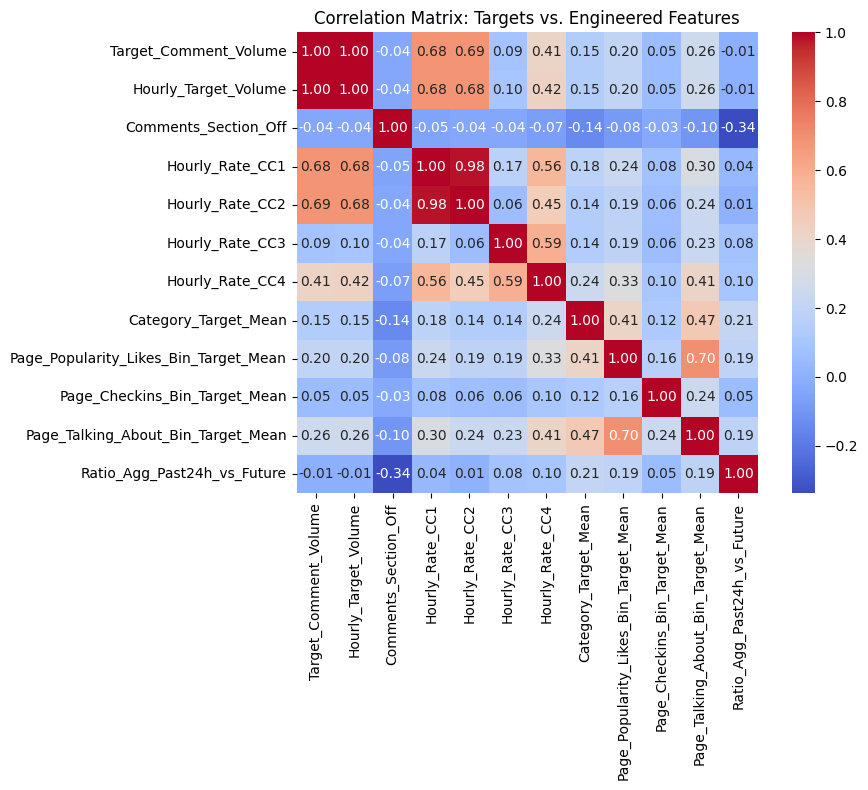

In [14]:

# 2) Select the newly added features + targets
corr_cols = [
    'Target_Comment_Volume',
    'Hourly_Target_Volume',
    'Comments_Section_Off',
    'Hourly_Rate_CC1',
    'Hourly_Rate_CC2',
    'Hourly_Rate_CC3',
    'Hourly_Rate_CC4',
    'Category_Target_Mean',
    'Page_Popularity_Likes_Bin_Target_Mean',
    'Page_Checkins_Bin_Target_Mean',
    'Page_Talking_About_Bin_Target_Mean',
    'Ratio_Agg_Past24h_vs_Future'
]

# 3) Compute correlation matrix
corr_matrix = train_df[corr_cols].corr()

# 4) Print and plot
print(corr_matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Correlation Matrix: Targets vs. Engineered Features")
plt.tight_layout()
plt.show()

Now we want to conduct first tests, to see if our features have a positive impact on model. Therefore we train a simple model on the raw data, and the data extended with out features.

In [15]:
X_train = train_df.drop(['Target_Comment_Volume', 'Hourly_Target_Volume'], axis=1)
y_train = train_df['Target_Comment_Volume']

X_test = test_df.drop(['Target_Comment_Volume', 'Hourly_Target_Volume'], axis=1)
y_test = test_df['Target_Comment_Volume']

X_train_raw = train_df_raw.drop(['Target_Comment_Volume', 'Hourly_Target_Volume'], axis=1)
y_train_raw = train_df_raw['Target_Comment_Volume']

X_test_raw = test_df_raw.drop(['Target_Comment_Volume', 'Hourly_Target_Volume'], axis=1)
y_test_raw = test_df_raw['Target_Comment_Volume']

In [16]:
cat_cols = ["Page_Category", "Post_Promotion_Status", "Published_Day", "BaseDate_Day"]

# drop them from each dataframe
X_train_no_cat     = X_train.drop(columns=cat_cols)
X_test_no_cat      = X_test.drop(columns=cat_cols)

X_train = pd.get_dummies(
    X_train,
    columns=["Page_Category", "Post_Promotion_Status", "Published_Day", "BaseDate_Day"],
    drop_first=True
)

X_test = pd.get_dummies(
    X_test,
    columns=["Page_Category", "Post_Promotion_Status", "Published_Day", "BaseDate_Day"],
    drop_first=True
)

X_train_raw = pd.get_dummies(
    X_train_raw,
    columns=["Page_Category", "Post_Promotion_Status", "Published_Day", "BaseDate_Day"],
    drop_first=True
)

X_test_raw = pd.get_dummies(
    X_test_raw,
    columns=["Page_Category", "Post_Promotion_Status", "Published_Day", "BaseDate_Day"],
    drop_first=True
)


In [17]:
from sklearn.tree import DecisionTreeRegressor

dt_raw = DecisionTreeRegressor(random_state=42)
dt_raw.fit(X_train_raw, y_train_raw)

# 5) Predict & evaluate
y_pred_raw = dt_raw.predict(X_test_raw)
mae = mean_absolute_error(y_test_raw, y_pred_raw)
mse = mean_squared_error(y_test_raw, y_pred_raw)

print("Decision Tree on Raw Original Data")
print(f"  MAE: {mae:.2f}")
print(f"  MSE: {mse:.2f}")

lr_raw = LinearRegression()
lr_raw.fit(X_train_raw, y_train_raw)

# Predict and evaluate
y_pred_lr = lr_raw.predict(X_test_raw)
mae_lr = mean_absolute_error(y_test_raw, y_pred_lr)
mse_lr = mean_squared_error(y_test_raw, y_pred_lr)

print("Linear Regression on Raw Original Data")
print(f"  MAE: {mae_lr:.2f}")
print(f"  MSE: {mse_lr:.2f}")

Decision Tree on Raw Original Data
  MAE: 4.50
  MSE: 686.67
Linear Regression on Raw Original Data
  MAE: 7.83
  MSE: 629.56


The prediction results are significantly better with our newly constructed features: Especially the MSE dropped, meaning there are less "very off" predictions

In [18]:

dt_orig = DecisionTreeRegressor(random_state=42)
dt_orig.fit(X_train, y_train)
y_pred_orig = dt_orig.predict(X_test)

mae_orig = mean_absolute_error(y_test, y_pred_orig)
mse_orig = mean_squared_error(y_test, y_pred_orig)

print("Decision Tree on Data with new Features")
print(f"  MAE: {mae_orig:.2f}")
print(f"  MSE: {mse_orig:.2f}\n")


lr_raw = LinearRegression()
lr_raw.fit(X_train, y_train)

# Predict and evaluate
y_pred_lr = lr_raw.predict(X_test)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
mse_lr = mean_squared_error(y_test, y_pred_lr)

print("Linear Regression on Data with new Features")
print(f"  MAE: {mae_lr:.2f}")
print(f"  MSE: {mse_lr:.2f}")

Decision Tree on Data with new Features
  MAE: 4.30
  MSE: 461.69

Linear Regression on Data with new Features
  MAE: 5.73
  MSE: 395.24


Feature Selection:

In [19]:
# from sklearn.feature_selection import RFE, SelectFromModel, SequentialFeatureSelector
# from sklearn.linear_model import LassoCV, LinearRegression
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.decomposition import PCA
# from sklearn.metrics import mean_absolute_error, mean_squared_error
# import pandas as pd

# # — assume X_train, X_test, y_train, y_test are already defined —

# # 1) Embedded: LassoCV + SelectFromModel
# lasso = LassoCV(cv=5, random_state=42, max_iter=10000)
# lasso.fit(X_train, y_train)
# sel_lasso = SelectFromModel(lasso, prefit=True, threshold='mean')
# X_tr_lasso = sel_lasso.transform(X_train)
# X_te_lasso = sel_lasso.transform(X_test)
# features_lasso = X_train.columns[sel_lasso.get_support()]

# # 2) Wrapper: RFE with LinearRegression (top 10)
# rfe = RFE(LinearRegression(), n_features_to_select=20)
# rfe.fit(X_train, y_train)
# X_tr_rfe = rfe.transform(X_train)
# X_te_rfe = rfe.transform(X_test)
# features_rfe = X_train.columns[rfe.support_]

# # 3) Stepwise: forward SFS for LinearRegression (top 10)
# sfs = SequentialFeatureSelector(LinearRegression(), n_features_to_select=20,
#                                 direction='forward', cv=5)
# sfs.fit(X_train, y_train)
# X_tr_sfs = sfs.transform(X_train)
# X_te_sfs = sfs.transform(X_test)
# features_sfs = X_train.columns[sfs.get_support()]

# # 4) PCA: reduce to 10 principal components (or change n_components)
# pca = PCA(n_components=20, random_state=42)
# pca.fit(X_train)
# X_tr_pca = pca.transform(X_train)
# X_te_pca = pca.transform(X_test)
# # note: PCA components aren't directly "features" you list

# # Helper to train & evaluate both models
# def eval_models(X_tr, X_te, y_tr, y_te):
#     lr = LinearRegression().fit(X_tr, y_tr)
#     dt = DecisionTreeRegressor(random_state=42).fit(X_tr, y_tr)
#     y_pred_lr = lr.predict(X_te)
#     y_pred_dt = dt.predict(X_te)
#     return {
#         'LR_MAE': mean_absolute_error(y_te, y_pred_lr),
#         'LR_MSE': mean_squared_error(y_te, y_pred_lr),
#         'DT_MAE': mean_absolute_error(y_te, y_pred_dt),
#         'DT_MSE': mean_squared_error(y_te, y_pred_dt),
#     }

# # Evaluate each method
# methods = [
#     ('Lasso', X_tr_lasso, X_te_lasso, features_lasso),
#     ('RFE',   X_tr_rfe,   X_te_rfe,   features_rfe),
#     ('SFS',   X_tr_sfs,   X_te_sfs,   features_sfs),
#     ('PCA',   X_tr_pca,   X_te_pca,   None),
# ]

# results = []
# for name, Xtr, Xte, feats in methods:
#     m = eval_models(Xtr, Xte, y_train, y_test)
#     m['Method'] = name
#     m['#Features'] = Xtr.shape[1]
#     results.append(m)

# # Summarize
# df_res = pd.DataFrame(results)[['Method','#Features','LR_MAE','LR_MSE','DT_MAE','DT_MSE']]
# print(df_res.to_string(index=False))

# # Print selected feature names where applicable
# print("\nLasso picked:", list(features_lasso))
# print("RFE picked  :", list(features_rfe))
# print("SFS picked  :", list(features_sfs))


Optimal feature count: 138
Selected features: ['Page_Checkins', 'Page_Talking_About', 'Derived_1', 'Derived_2', 'Derived_3', 'Derived_4', 'Derived_5', 'Derived_6', 'Derived_7', 'Derived_8', 'Derived_9', 'Derived_10', 'Derived_11', 'Derived_12', 'Derived_13', 'Derived_14', 'Derived_15', 'Derived_16', 'Derived_17', 'Derived_18', 'Derived_19', 'Derived_20', 'Derived_21', 'Derived_22', 'Derived_23', 'Derived_24', 'Derived_25', 'CC1_Total_Comments', 'CC2_Comments_Last_24h', 'CC3_Comments_48_to_24h', 'CC4_Comments_First_24h', 'CC5_CC2_CC3_Difference', 'Base_Time', 'Post_Length', 'Post_Share_Count', 'H_Local', 'Comments_Section_Off', 'Hourly_Rate_CC1', 'Hourly_Rate_CC2', 'Hourly_Rate_CC3', 'Hourly_Rate_CC4', 'Category_Target_Mean', 'Page_Popularity_Likes_Bin_Target_Mean', 'Page_Checkins_Bin_Target_Mean', 'Page_Talking_About_Bin_Target_Mean', 'Ratio_Agg_Past24h_vs_Future', 'Page_Category_Album', 'Page_Category_App page', 'Page_Category_Artist', 'Page_Category_Arts/entertainment/nightlife', 'Pa

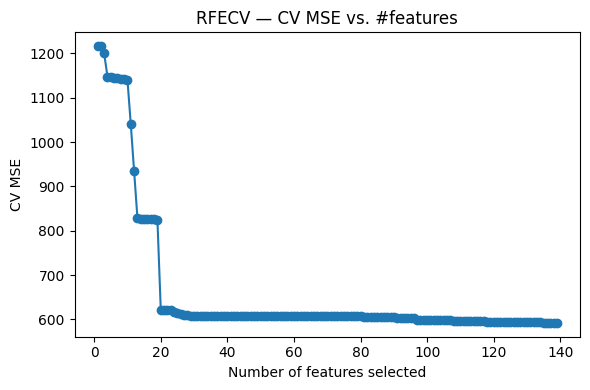

LinearRegression on RFECV features — MAE: 5.73, MSE: 395.42
DecisionTreeRegressor on RFECV features — MAE: 4.27, MSE: 483.93


In [24]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# Base estimator for ranking
est = LinearRegression()

# RFECV: step=1 removes one feature at a time, cv=5 folds
rfecv = RFECV(
    estimator=est,
    step=1,
    cv=5,
    scoring='neg_mean_squared_error',
    min_features_to_select=1,
    n_jobs=-1
)
rfecv.fit(X_train, y_train)

opt_n = rfecv.n_features_
print("Optimal feature count:", opt_n)
selected = X_train.columns[rfecv.support_]
print("Selected features:", list(selected))

# Extract the CV‐fold MSE for each number of features
# Note: mean_test_score is negative MSE (because scoring='neg_mean_squared_error')
mse_scores = -rfecv.cv_results_['mean_test_score']

# Plot MSE vs. #features
plt.figure(figsize=(6,4))
plt.plot(
    np.arange(1, len(mse_scores) + 1),
    mse_scores,
    marker='o'
)
plt.xlabel("Number of features selected")
plt.ylabel("CV MSE")
plt.title("RFECV — CV MSE vs. #features")
plt.tight_layout()
plt.show()

# And then re‐fit on the selected subset
X_tr_rfecv = rfecv.transform(X_train)
X_te_rfecv = rfecv.transform(X_test)

for Model in (LinearRegression, DecisionTreeRegressor):
    m = Model().fit(X_tr_rfecv, y_train)
    pred = m.predict(X_te_rfecv)
    print(f"{Model.__name__} on RFECV features — MAE: {mean_absolute_error(y_test, pred):.2f}, "
          f"MSE: {mean_squared_error(y_test, pred):.2f}")

!!! Not using categorical variables due to compute time

In [25]:
# pip install mlxtend
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Floating SFS: k_features='best' lets it decide how many features to keep
sfs = SFS(
    estimator=LinearRegression(),
    k_features='best',
    forward=True,
    floating=True,
    scoring='neg_mean_squared_error',
    cv=5,
    n_jobs=-1
)
sfs = sfs.fit(X_train_no_cat.values, y_train.values)

feat_idx = list(sfs.k_feature_idx_)
feat_names = X_train_no_cat.columns[feat_idx]
print("Best #features:", len(feat_idx))
print("Selected features:", feat_names)

# Transform and evaluate
X_tr = sfs.transform(X_train_no_cat.values)
X_te = sfs.transform(X_test_no_cat.values)
for Model in (LinearRegression, DecisionTreeRegressor):
    m = Model().fit(X_tr, y_train)
    pred = m.predict(X_te)
    print(f"{Model.__name__} — MAE: {mean_absolute_error(y_test, pred):.2f}, "
          f"MSE: {mean_squared_error(y_test, pred):.2f}")


Best #features: 28
Selected features: Index(['Page_Checkins', 'Page_Talking_About', 'Derived_2', 'Derived_3',
       'Derived_7', 'Derived_11', 'Derived_12', 'Derived_13', 'Derived_18',
       'Derived_19', 'Derived_21', 'Derived_22', 'Derived_23', 'Derived_25',
       'CC2_Comments_Last_24h', 'CC3_Comments_48_to_24h',
       'CC4_Comments_First_24h', 'CC5_CC2_CC3_Difference', 'Base_Time',
       'Post_Length', 'Post_Share_Count', 'H_Local', 'Comments_Section_Off',
       'Hourly_Rate_CC1', 'Hourly_Rate_CC3',
       'Page_Popularity_Likes_Bin_Target_Mean',
       'Page_Talking_About_Bin_Target_Mean', 'Ratio_Agg_Past24h_vs_Future'],
      dtype='object')
LinearRegression — MAE: 5.66, MSE: 395.19
DecisionTreeRegressor — MAE: 4.44, MSE: 511.95


--> Some of our added features were selected as relevant !!!